# exp37

lag_diffのXGB


https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7977

In [1]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

import lightgbm as lgb
import xgboost as xgb


In [2]:
print(xgb.__version__)

1.5.0


In [3]:

# ====================================================
# Get the difference
# ====================================================
def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        # Get the differences
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    # Concatenate
    df1 = np.concatenate(df1, axis = 0)
    # Transform to dataframe
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # Add customer id
    df1['customer_ID'] = customer_ids
    return df1

# ====================================================
# Read & preprocess data and save it to disk
# ====================================================
def read_preprocess_data():
    train = pd.read_parquet('/content/data/train.parquet')
    features = train.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features]
    print('Starting training feature engineer...')
    train_num_agg = train.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
    # Transform float64 columns to float32
    cols = list(train_num_agg.dtypes[train_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(train_cat_agg.dtypes[train_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int32)
    # Get the difference
    train_diff = get_difference(train, num_features)
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg, train_diff
    gc.collect()
    test = pd.read_parquet('../input/amex-fe/test_fe.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    # Transform float64 columns to float32
    cols = list(test_num_agg.dtypes[test_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(test_cat_agg.dtypes[test_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        test_cat_agg[col] = test_cat_agg[col].astype(np.int32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg, test_diff
    gc.collect()
    # Save files to disk
    train.to_parquet('../input/amex-fe/train_fe.parquet')
    test.to_parquet('../input/amex-fe/test_fe.parquet')

# Read & Preprocess Data
read_preprocess_data()

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/train.parquet'

# Training & Inference

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations

import pickle

# ====================================================
# Configurations
# ====================================================
class CFG:
    
    
    # input_dir = '../feature/exp35_lagdiff/'
    input_dir = '../feature/exp03_amex-fe/'
    output_dir = '../output/exp50_cat_lagdiff_c3_statedate/'
    seed = 42
    n_folds = 5
    target = 'target'
    boosting_type = 'dart'
    metric = 'binary_logloss'
    model = "cat"
    ver = "exp50"

# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ====================================================
# Read data
# ====================================================
# def read_data():
#     train = pd.read_parquet(CFG.input_dir + 'train_diff.parquet')
#     test = pd.read_parquet(CFG.input_dir + 'test_diff.parquet')
#     return train, test

def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_plus_plus.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_plus_plus.parquet')
    return train, test

# ====================================================
# Amex metric
# ====================================================
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

# ====================================================
# LGBM amex metric
# ====================================================
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True


In [6]:
seed_everything(CFG.seed)

train = pd.read_pickle('../feature/exp50_lagdiff_c3_statedate/train_lagdiff_c3_statedate.pkl')
test = pd.read_pickle('../feature/exp50_lagdiff_c3_statedate/test_lagdiff_c3_statedate.pkl')

# train_sd = pd.read_pickle("../feature/Statement Dates/train_SDist.pkl")
# test_sd = pd.read_pickle("../feature/Statement Dates/test_SDist.pkl")


# train = pd.read_parquet('../feature/exp35_lagdiff/train_lagdiff.parquet')
# test = pd.read_parquet('../feature/exp35_lagdiff/test_lagdiff.parquet')

# # train, test = read_data()

# train_c3 = pd.read_pickle('../feature/exp18_4_tsfresh/train_c3.pkl')
# test_c3 = pd.read_pickle('../feature/exp18_4_tsfresh/test_c3.pkl')

# train = train.merge(train_sd,on = "customer_ID",how = "left")
# test = test.merge(test_sd,on = "customer_ID",how = "left")

# del train_sd,test_sd
# gc.collect

print(train.shape)
print(test.shape)

(458913, 2025)
(924621, 2024)


In [7]:

def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())


def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

In [8]:

from catboost import CatBoostClassifier

cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]

# kmeans_list = ["kmeans pred 2","kmeans pred 3","kmeans pred 4"]

cat_features = [f"{cf}_last" for cf in cat_features]
# cat_features.extend(kmeans_list)

for cat_col in cat_features:
#     print(cat_col)
    encoder = LabelEncoder()
    train[cat_col] = encoder.fit_transform(train[cat_col])
    test[cat_col] = encoder.transform(test[cat_col])


features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]

prams = {
    'depth': 8,
    'iterations':9999,#9999
    'learning_rate': 0.02,
    'random_state':CFG.seed,
    'task_type':"CPU",
    'early_stopping_rounds': 300,
    # 'custom_metric' : 'cat_amex'
}

# Create a numpy array to store test predictions
test_predictions = np.zeros(len(test))
# Create a numpy array to store out of folds predictions
oof_predictions = []

cids = []
tr_target = []

# epoch = [10000,7500,7500,8500,10500]

kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {len(features)} features...')
    x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
    y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
    
    # dtrain = xgb.DMatrix(data=x_train, label=y_train)
    # dvalid = xgb.DMatrix(data=x_val, label=y_val)
    # dtest = xgb.DMatrix(data=test[features])
    
#     des = DartEarlyStopping("valid_1", CFG.metric, 1000)
  
    model = CatBoostClassifier(**prams)
    
    model.fit(x_train, y_train,
                  eval_set = [(x_val, y_val)], 
                  metric_period=100
                 )
    
#     model = lgb.train(
#         params = params,
#         train_set = lgb_train,
#         num_boost_round = epoch[fold],#10500
#         valid_sets = [lgb_train, lgb_valid],
#         early_stopping_rounds = 1500,
# #         eval_metric=[lgb_amex_metric],
#         verbose_eval = 500,
#         feval = lgb_amex_metric
#         )
    
    # Save best model
    model.save_model(f"{CFG.output_dir}{CFG.model}_fold{fold}_seed{CFG.seed}.cbm")
    joblib.dump(model, f'{CFG.output_dir}lgbm_{CFG.boosting_type}_fold{fold}_seed{CFG.seed}.pkl')
    # Predict validation
    
    val_pred = model.predict_proba(x_val)[:,1]
    oof_predictions.extend(val_pred)
    
    
    cids.extend(train["customer_ID"].loc[val_ind])
    tr_target.extend(train["target"].loc[val_ind])
    
    # Predict the test set
    test_pred = model.predict_proba(test[features])[:,1]
    # test_pred = model.predict(test[features])
    test_predictions += test_pred / CFG.n_folds
    # Compute fold metric
    
    score = amex_metric(y_val, val_pred)
    print(f'Our fold {fold} CV score is {score}')
    del x_train, x_val, y_train, y_val
    gc.collect()
    
# Compute out of folds metric
score = amex_metric(tr_target, oof_predictions)
print(f'Our out of folds CV score is {score}')


# Create a dataframe to store test prediction
test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
# test_df.to_csv(f'{CFG.output_dir}test_{CFG.model}_{score}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
test_df.to_csv(f'{CFG.output_dir}test_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


dic_oof = {
    "customer_ID":cids,
    "target":tr_target,
    f"{CFG.ver}_{CFG.model}_oof":oof_predictions
}

# Create a dataframe to store out of folds predictions
oof_df = pd.DataFrame(dic_oof)
# oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
oof_df.to_csv(f'{CFG.output_dir}oof_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)



# # Create a dataframe to store out of folds predictions
# oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
# oof_df.to_csv(f'../output/Amex LGBM Dart CV 0.7977/oof_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


# # Create a dataframe to store test prediction
# test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
# test_df.to_csv(f'../output/Amex LGBM Dart CV 0.7977/test_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


 
--------------------------------------------------
Training fold 0 with 2023 features...


0:	learn: 0.6666713	test: 0.6665801	best: 0.6665801 (0)	total: 840ms	remaining: 2h 19m 58s
100:	learn: 0.2440632	test: 0.2436376	best: 0.2436376 (100)	total: 1m 9s	remaining: 1h 53m 30s
200:	learn: 0.2291157	test: 0.2296980	best: 0.2296980 (200)	total: 2m 16s	remaining: 1h 51m 9s
300:	learn: 0.2234676	test: 0.2252200	best: 0.2252200 (300)	total: 3m 23s	remaining: 1h 49m 32s
400:	learn: 0.2196969	test: 0.2227170	best: 0.2227170 (400)	total: 4m 30s	remaining: 1h 47m 57s
500:	learn: 0.2169216	test: 0.2211465	best: 0.2211465 (500)	total: 5m 37s	remaining: 1h 46m 44s
600:	learn: 0.2144739	test: 0.2199916	best: 0.2199916 (600)	total: 6m 43s	remaining: 1h 45m 9s
700:	learn: 0.2120083	test: 0.2190870	best: 0.2190870 (700)	total: 7m 52s	remaining: 1h 44m 23s
800:	learn: 0.2096348	test: 0.2183694	best: 0.2183694 (800)	total: 8m 57s	remaining: 1h 42m 46s
900:	learn: 0.2074275	test: 0.2178640	best: 0.2178640 (900)	total: 10m 4s	remaining: 1h 41m 45s
1000:	learn: 0.2054126	test: 0.2174640	best: 0.2

0:	learn: 0.6663197	test: 0.6663039	best: 0.6663039 (0)	total: 775ms	remaining: 2h 9m 10s
100:	learn: 0.2432105	test: 0.2447661	best: 0.2447661 (100)	total: 1m 12s	remaining: 1h 59m 3s
200:	learn: 0.2283197	test: 0.2317001	best: 0.2317001 (200)	total: 2m 22s	remaining: 1h 55m 29s
300:	learn: 0.2226394	test: 0.2274801	best: 0.2274801 (300)	total: 3m 30s	remaining: 1h 53m 10s
400:	learn: 0.2189235	test: 0.2251866	best: 0.2251866 (400)	total: 4m 39s	remaining: 1h 51m 19s
500:	learn: 0.2160137	test: 0.2237084	best: 0.2237084 (500)	total: 5m 48s	remaining: 1h 50m 2s
600:	learn: 0.2135561	test: 0.2226505	best: 0.2226505 (600)	total: 6m 57s	remaining: 1h 48m 52s
700:	learn: 0.2111418	test: 0.2218346	best: 0.2218346 (700)	total: 8m 8s	remaining: 1h 47m 57s
800:	learn: 0.2087545	test: 0.2211944	best: 0.2211944 (800)	total: 9m 17s	remaining: 1h 46m 46s
900:	learn: 0.2064980	test: 0.2207277	best: 0.2207277 (900)	total: 10m 27s	remaining: 1h 45m 32s
1000:	learn: 0.2044044	test: 0.2203871	best: 0.2

0:	learn: 0.6663695	test: 0.6664397	best: 0.6664397 (0)	total: 704ms	remaining: 1h 57m 17s
100:	learn: 0.2431038	test: 0.2451029	best: 0.2451029 (100)	total: 1m 9s	remaining: 1h 53m 18s
200:	learn: 0.2283869	test: 0.2317666	best: 0.2317666 (200)	total: 2m 14s	remaining: 1h 49m 29s
300:	learn: 0.2227001	test: 0.2274790	best: 0.2274790 (300)	total: 3m 20s	remaining: 1h 47m 53s
400:	learn: 0.2190049	test: 0.2251348	best: 0.2251348 (400)	total: 4m 26s	remaining: 1h 46m 21s
500:	learn: 0.2161721	test: 0.2236208	best: 0.2236208 (500)	total: 5m 31s	remaining: 1h 44m 40s
600:	learn: 0.2137192	test: 0.2225686	best: 0.2225686 (600)	total: 6m 36s	remaining: 1h 43m 17s
700:	learn: 0.2113207	test: 0.2217051	best: 0.2217051 (700)	total: 7m 40s	remaining: 1h 41m 52s
800:	learn: 0.2090057	test: 0.2210156	best: 0.2210156 (800)	total: 8m 44s	remaining: 1h 40m 25s
900:	learn: 0.2068579	test: 0.2204802	best: 0.2204802 (900)	total: 9m 46s	remaining: 1h 38m 44s
1000:	learn: 0.2048320	test: 0.2201189	best: 0

0:	learn: 0.6672453	test: 0.6673725	best: 0.6673725 (0)	total: 680ms	remaining: 1h 53m 15s
100:	learn: 0.2430787	test: 0.2463725	best: 0.2463725 (100)	total: 1m 8s	remaining: 1h 51m 28s
200:	learn: 0.2281307	test: 0.2329538	best: 0.2329538 (200)	total: 2m 14s	remaining: 1h 49m 12s
300:	learn: 0.2226103	test: 0.2288085	best: 0.2288085 (300)	total: 3m 19s	remaining: 1h 47m 11s
400:	learn: 0.2188789	test: 0.2264208	best: 0.2264208 (400)	total: 4m 25s	remaining: 1h 45m 51s
500:	learn: 0.2160322	test: 0.2248972	best: 0.2248972 (500)	total: 5m 29s	remaining: 1h 44m 9s
600:	learn: 0.2135432	test: 0.2237640	best: 0.2237640 (600)	total: 6m 34s	remaining: 1h 42m 51s
700:	learn: 0.2111571	test: 0.2228890	best: 0.2228890 (700)	total: 7m 38s	remaining: 1h 41m 25s
800:	learn: 0.2087712	test: 0.2222017	best: 0.2222017 (800)	total: 8m 42s	remaining: 1h 39m 58s
900:	learn: 0.2065566	test: 0.2216631	best: 0.2216631 (900)	total: 9m 45s	remaining: 1h 38m 35s
1000:	learn: 0.2045800	test: 0.2212732	best: 0.

0:	learn: 0.6660221	test: 0.6660577	best: 0.6660577 (0)	total: 732ms	remaining: 2h 2m 3s
100:	learn: 0.2435738	test: 0.2442220	best: 0.2442220 (100)	total: 1m 8s	remaining: 1h 52m 30s
200:	learn: 0.2287184	test: 0.2304148	best: 0.2304148 (200)	total: 2m 14s	remaining: 1h 49m 22s
300:	learn: 0.2230916	test: 0.2260197	best: 0.2260197 (300)	total: 3m 20s	remaining: 1h 47m 53s
400:	learn: 0.2195512	test: 0.2237657	best: 0.2237657 (400)	total: 4m 26s	remaining: 1h 46m 24s
500:	learn: 0.2166885	test: 0.2222252	best: 0.2222252 (500)	total: 5m 33s	remaining: 1h 45m 24s
600:	learn: 0.2142303	test: 0.2210479	best: 0.2210479 (600)	total: 6m 39s	remaining: 1h 44m
700:	learn: 0.2118199	test: 0.2201134	best: 0.2201134 (700)	total: 7m 44s	remaining: 1h 42m 44s
800:	learn: 0.2094612	test: 0.2193835	best: 0.2193835 (800)	total: 8m 48s	remaining: 1h 41m 6s
900:	learn: 0.2072819	test: 0.2188744	best: 0.2188744 (900)	total: 9m 51s	remaining: 1h 39m 37s
1000:	learn: 0.2052153	test: 0.2184439	best: 0.218443

<AxesSubplot:>

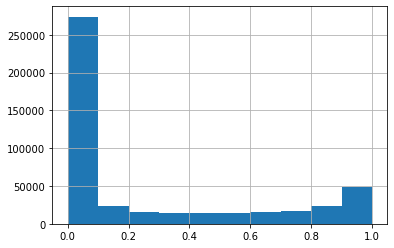

In [9]:
oof_df[f"{CFG.ver}_{CFG.model}_oof"].hist()